# 1 準備

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# データ作成に使用するライブラリ
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# モデル作成に使用するライブラリ
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# よく使用するライブラリ
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)

In [3]:
# データの読み込み
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
root = './data'
mnist_dataset = datasets.MNIST(root=root,download=True,train=True,transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=100,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# gpuの指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# 2 モデル

In [5]:
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        return y, z

    def reparameterize(self, mean, var):
        z = mean + torch.sqrt(var) * torch.randn(mean.size()).to(self.device)
        return z

    def criterion(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)
        L1 =  - torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y), dim=1))
        L2 = - 1/2 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var, dim=1))
        L =  L1 + L2

        return L

In [6]:
class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.l_mean = nn.Linear(128, 2)
        self.l_var = nn.Linear(128, 2)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        mean = self.l_mean(h)
        var = self.l_var(h)
        var = F.softplus(var)

        return mean, var

In [7]:
class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(2, 128)
        self.l2 = nn.Linear(128, 256)
        self.out = nn.Linear(256, 784)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.sigmoid(h)

        return y

In [8]:
model = VAE(device=device).to(device)
criterion = model.criterion
optimizer = optim.Adam(model.parameters())

# 3 モデルの学習

In [9]:
n_epoch = 8

for epoch in range(n_epoch):
    loss_mean = 0.
    for (x, t) in dataloader:

      # 学習準備
      x = x.to(device)
      model.train()
      
      # モデルの学習
      loss = criterion(x)
      optimizer.zero_grad()
      loss.backward()     
      optimizer.step()

      # 損失関数の計算
      loss_mean += loss.item()
    loss_mean /= len(dataloader)

    print('Epoch: {}, Loss: {:.3f}'.format(epoch+1, loss_mean))

Epoch: 1, Loss: 185.716
Epoch: 2, Loss: 162.301
Epoch: 3, Loss: 156.590
Epoch: 4, Loss: 153.005
Epoch: 5, Loss: 150.564
Epoch: 6, Loss: 148.899
Epoch: 7, Loss: 147.380
Epoch: 8, Loss: 146.372


# 4 画像の生成

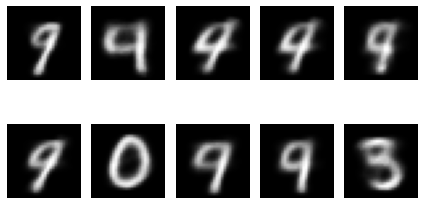

In [10]:
# データの生成
model.eval()
z = torch.randn(10, 2, device = device)
images = model.decoder(z)
images = images.view(-1, 28, 28)
images = images.squeeze().detach().cpu().numpy()

# データの可視化
for i, image in enumerate(images):
    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

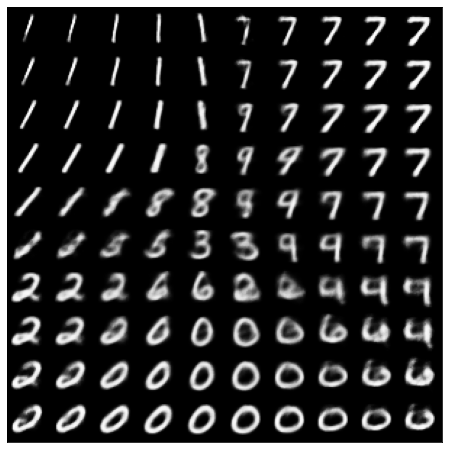

In [11]:
# データ可視化の前準備
img_size=28
n_image = 10
img_size_spaced = img_size + 2
matrix_image = np.zeros((img_size_spaced*n_image, img_size_spaced*n_image))  # 全体の画像

# 潜在変数の作成
z_1 = torch.linspace(-3, 3, n_image)  # 行
z_2 = torch.linspace(-3, 3, n_image)  # 列

#  潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        x = torch.tensor([float(z1), float(z2)], device=device)
        images = model.decoder(x)
        images = images.view(-1, 28, 28)
        images = images.squeeze().detach().cpu().numpy()
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top : top+img_size, left : left+img_size] = images

# データの可視化
plt.figure(figsize=(8, 8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
plt.show()